<div align="right"><i>Peter Norvig<br>3 October 2019</i></div>

# Tracking Trump: Electoral Votes Edition

Sites such as [RealClearPolitics](https://www.realclearpolitics.com/epolls/other/president_trump_job_approval-6179.html),  [538](https://projects.fivethirtyeight.com/trump-approval-ratings/), and [Mourning Consult](https://morningconsult.com/tracking-trump/) track Trump's approval ratings.  He currently stands at 41% approval and 54% disapproval for a **net approval** of -13%. Can we use approval ratings to predict election results? There are four big caveats:

1. Today is not election day 2020. 

2. We don't know for sure that Trump will run in 2020.

3. Approval polls are not votes. 

4. Popular votes are not electoral votes. 

We can't be conclusive about the first three points. But can we use state-by-state approval polls to 
compute expected electoral votes, under the assumption that Trump wins the electoral votes of states where he has positive net approval and loses the states with negative net approval? *Yes we can!*


# TL;DR 

As of September 1, 2019, Trump would get  _**166 electoral votes**_  under these assumptions (you need **270** to win). 


___

# Details for data science nerds

View, verify, or modify **[my code](ElectoralVotesCode.ipynb)**.

# Details for policy wonks

The following plot shows, for each month in office, the expected number of electoral votes with error bars indicating a 3% swing in either direction (Why 3%? That was the [average error](https://fivethirtyeight.com/features/the-polls-are-all-right/) in national presidential polls in 2016: Clinton was predicted by National polls to win the popular vote by 6% but actually only won by 3%.) Trump hasn't been above 270 since 4 months into his term, and even with the 3% swing, since 6 months in. He's been below 200 for 10 months in a row (or below 230 counting the 3% swing).

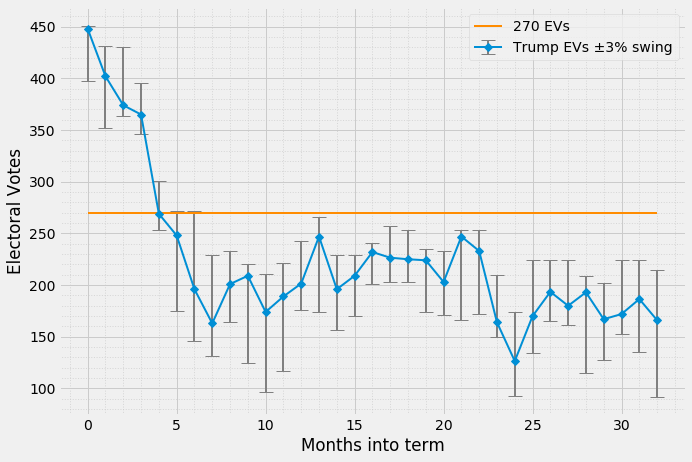

In [1]:
%run ElectoralVotesCode.ipynb
show_months()

# State-by-state summary table

There's a lot of uncertainty. We don't know who else will be on the ballot and what their approval levels will be, we don't know if there is systematic bias in the polling data, we don't know who will decide not to vote, we don't know who will be prevented from voting by interference foreign or domestic, we don't know if future events will change voters' perceptions.
I have five ways of understanding the fluidity of the situation:

- **Undecided**: Undecided voters could make up their minds late in the election cycle. But there are few undecided voters: in most states, only 3% or 4%. In [one poll](https://www.pbs.org/newshour/politics/57-percent-of-voters-say-they-wont-support-trump-in-2020) 57% said they would definitely not vote for Trump in 2020; other polls have this in the 50% to 55% range.

- **Variance**: How much are voters changing their minds from month to month in each state?  I track the standard deviation, 𝝈, of the net approval for each state over the last 12 months.

- **Movement**: What's the most a state's net approval could be expected to move, due to random fluctuations (that is, assuming there is no big future event that changes people's minds)? I define the maximum expected  **movement** of a state as 1/5 of the undecided voters (i.e. assume the undecided voters broke 60/40 one way or the other) plus 2 standard deviations in the net approval over the last 12 months. 

- **Swing state**: I define a swing state as one whose maximum expected movement is greater than the absolute value of the net approval. There are 16 such states now; if Trump won them all, he would still lose the election with only 253 electoral votes. The swing states are shown below in **BOLD CAPS**.

- **Margin**: If you list states in order of approval, the key turning-point state is Pennsylvania; Trump would need to win that and every state in which he is more popular. He currently is **7% behind in Pennsylvania**, so we say that his **margin is 7%**.


The following table packs in a lot of information. States are sorted by net approval. The columns are:

- **State**: name of state. 
- **Net**: President's current net approval in state.
- **Move**:  Expected maximum movement: 1/5 of the undecided voters  plus 2 standard deviations in the net approval over the last 12 months.
- **EV**: State's number of electoral votes.
- **ΣEV**: Cumulative running sum of electoral votes of this state and all states above.
- **+**: President's current approval in state.
- **-**: President's current disapproval in state.
- **?**: Undecideds in state.
- **𝝈**: Standard deviation in net approval over the past 12 months in state.
- **Δ**: President's change in net approval from inauguration date to today in state. 

The table shows that:
- If Trump loses all the swing states, he gets **70** electoral votes (the **ΣEV** in the South Carolina row).
- If he wins the states he is leading in, he gets **166** electoral votes (the **ΣEV** in the South Dakota row).
- If he wins all the swing states, he gets **253** electoral votes (**ΣEV** in the **OHIO** row); still not enough.
- To get to **270**, he would need Pennsylvania (where he is currently -7%), or some combination of states where he trails by double digits.


In [2]:
show_states()

|State|Net|Move|EV|ΣEV|+|−|?|𝝈|Δ|
|-|-|-|-|-|-|-|-|-|-|
|Alabama|+22%|±6%|9|9|59%|37%|4%|±2.7%|-14%|
|Mississippi|+21%|±6%|6|15|59%|38%|3%|±2.8%|-13%|
|Idaho|+20%|±6%|4|19|58%|38%|4%|±2.7%|-9%|
|West Virginia|+19%|±8%|5|24|58%|39%|3%|±3.8%|-18%|
|Wyoming|+16%|±12%|3|27|57%|41%|2%|±5.8%|-24%|
|Kentucky|+15%|±3%|8|35|56%|41%|3%|±1.1%|-19%|
|Louisiana|+15%|±6%|8|43|56%|41%|3%|±2.7%|-16%|
|Tennessee|+13%|±7%|11|54|55%|42%|3%|±3.2%|-20%|
|Oklahoma|+11%|±7%|7|61|54%|43%|3%|±3.0%|-23%|
|South Carolina|+7%|±5%|9|70|52%|45%|3%|±2.4%|-18%|
|**MISSOURI**|**+5%**|**±7%**|10|80|51%|46%|3%|±3.3%|-14%|
|**ARKANSAS**|**+4%**|**±7%**|6|86|50%|46%|4%|±3.1%|-26%|
|**KANSAS**|**+4%**|**±6%**|6|92|50%|46%|4%|±2.4%|-20%|
|**INDIANA**|**+2%**|**±6%**|11|103|49%|47%|4%|±2.5%|-20%|
|**TEXAS**|**+2%**|**±5%**|38|141|49%|47%|4%|±2.0%|-18%|
|**ALASKA**|**+1%**|**±10%**|3|144|48%|47%|5%|±4.7%|-23%|
|**GEORGIA**|**+1%**|**±5%**|16|160|49%|48%|3%|±2.3%|-17%|
|**NORTH DAKOTA**|**+1%**|**±8%**|3|163|49%|48%|3%|±3.6%|-22%|
|**SOUTH DAKOTA**|**+1%**|**±11%**|3|166|49%|48%|3%|±5.1%|-20%|
|**FLORIDA**|**-1%**|**±4%**|29|195|48%|49%|3%|±1.9%|-23%|
|**ARIZONA**|**-3%**|**±6%**|11|206|47%|50%|3%|±2.9%|-23%|
|**MONTANA**|**-3%**|**±9%**|3|209|47%|50%|3%|±4.1%|-27%|
|**NEBRASKA**|**-3%**|**±8%**|5|214|47%|50%|3%|±3.7%|-26%|
|**NORTH CAROLINA**|**-3%**|**±5%**|15|229|47%|50%|3%|±2.2%|-21%|
|**UTAH**|**-3%**|**±7%**|6|235|47%|50%|3%|±3.2%|-30%|
|**OHIO**|**-5%**|**±5%**|18|253|46%|51%|3%|±2.4%|-19%|
|Pennsylvania|-7%|±3%|20|273|45%|52%|3%|±1.4%|-17%|
|Virginia|-7%|±5%|13|286|45%|52%|3%|±2.0%|-15%|
|Michigan|-10%|±5%|16|302|43%|53%|4%|±2.1%|-18%|
|Delaware|-11%|±5%|3|305|43%|54%|3%|±2.0%|-19%|
|Minnesota|-11%|±5%|10|315|43%|54%|3%|±2.4%|-14%|
|Nevada|-11%|±6%|6|321|43%|54%|3%|±2.6%|-21%|
|Wisconsin|-11%|±5%|10|331|43%|54%|3%|±2.1%|-17%|
|Iowa|-13%|±5%|6|337|42%|55%|3%|±2.0%|-22%|
|Maine|-13%|±6%|4|341|42%|55%|3%|±2.9%|-21%|
|Colorado|-15%|±6%|9|350|41%|56%|3%|±2.5%|-16%|
|New Mexico|-15%|±6%|5|355|41%|56%|3%|±2.9%|-32%|
|New Jersey|-17%|±4%|14|369|40%|57%|3%|±1.9%|-19%|
|Rhode Island|-20%|±4%|4|373|38%|58%|4%|±1.7%|-16%|
|Illinois|-22%|±4%|20|393|37%|59%|4%|±1.4%|-31%|
|New Hampshire|-22%|±10%|4|397|38%|60%|2%|±4.7%|-23%|
|Connecticut|-23%|±5%|7|404|37%|60%|3%|±2.3%|-28%|
|New York|-23%|±4%|29|433|37%|60%|3%|±1.5%|-31%|
|Oregon|-24%|±5%|7|440|36%|60%|4%|±1.9%|-26%|
|Maryland|-25%|±5%|10|450|36%|61%|3%|±2.3%|-12%|
|California|-28%|±4%|55|505|34%|62%|4%|±1.8%|-22%|
|Washington|-29%|±6%|12|517|34%|63%|3%|±2.7%|-30%|
|Hawaii|-30%|±9%|4|521|33%|63%|4%|±4.3%|-17%|
|Massachusetts|-31%|±5%|11|532|33%|64%|3%|±2.2%|-27%|
|Vermont|-33%|±8%|3|535|32%|65%|3%|±3.7%|-31%|
|District of Columbia|-55%|±6%|3|538|21%|76%|3%|±2.5%|-24%|

# Margin and country-wide net approval by month

The next plot gives the swing margin needed to reach 270 for each month, along with the country-wide net approval. Trump has been in negative territory on all metrics since his fourth month in office. He's been net -10% or worse country-wide every month since his third in office. His necessary margin has been 7% or worse  for nine months in a row. We see that the state-by-state margin roughly correlates with the country-wide net approval, but not exactly.

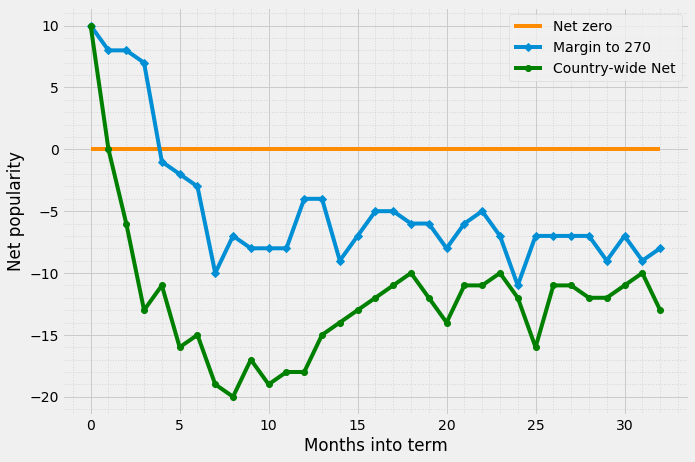

In [3]:
show_approval()

# Popularity Above Replacement President (PARP) 

Fivethirtyeight is a combination sports/politics site, and it has a lot of statistics about sports players and how much better they are than the average replacement player. Given that, they [decided](https://fivethirtyeight.com/features/the-states-where-trump-is-more-and-less-popular-than-he-should-be/) to rate the president's approval versus each state's overall approval of his party (in recent elections), which is a way of rating the president's performance versus an average replacement candidate from the same party. I'll duplicate that work and keep it up to date.

Trump is much less popular than the average Republican. There are only three states where Trump is exceeding a replacement Republican (i.e., has a positive PARP): one deep-red southern state, Mississippi, and two deep-blue coastal states, Hawaii and Rhode Island (where he is deeply unpopular, but not as unpopular as other Republicans). Again, the swing states are **BOLD CAPITALIZED**.  

For comparison, we show PARP and net approval today as well as in January of 2019, 2018, and 2017. Trump was more popular than an average Republican at his inauguration in January 2017, with positive PARP in 42 states. But by 2018 he had positive PARP in only 6 states, and today only 3.

In [4]:
show_parp()

|State|Lean|EV|PARP |Net |PARP 19|Net 19|PARP 18|Net 18|PARP 17|Net 17|
|-|-|-|-|-|-|-|-|-|-|-|
|Hawaii|-36|4|+6|-30|+7|-29|+0|-36|+23|-13|
|Mississippi|+15|6|+6|+21|-2|+13|+2|+17|+19|+34|
|Rhode Island|-26|4|+6|-20|+7|-19|+4|-22|+22|-4|
|Delaware|-14|3|+3|-11|-1|-15|+0|-14|+22|+8|
|New York|-22|29|-1|-23|-2|-24|+4|-18|+30|+8|
|Louisiana|+17|8|-2|+15|-2|+15|+2|+19|+14|+31|
|Maryland|-23|10|-2|-25|-7|-30|+0|-23|+10|-13|
|Massachusetts|-29|11|-2|-31|-2|-31|-3|-32|+25|-4|
|California|-24|55|-4|-28|-6|-30|+1|-23|+18|-6|
|New Jersey|-13|14|-4|-17|-6|-19|-3|-16|+15|+2|
|Alabama|+27|9|-5|+22|-7|+20|+3|+30|+9|+36|
|**FLORIDA**|+5|29|-6|-1|-9|-4|+0|+5|+17|+22|
|Virginia|+0|13|-7|-7|-10|-10|-4|-4|+8|+8|
|Kentucky|+23|8|-8|+15|-9|+14|-8|+15|+11|+34|
|Maine|-5|4|-8|-13|-6|-11|-11|-16|+13|+8|
|New Mexico|-7|5|-8|-15|-11|-18|-13|-20|+24|+17|
|**NORTH CAROLINA**|+5|15|-8|-3|-9|-4|-6|-1|+13|+18|
|Pennsylvania|+1|20|-8|-7|-11|-10|-4|-3|+9|+10|
|Illinois|-13|20|-9|-22|-10|-23|-8|-21|+22|+9|
|Michigan|-1|16|-9|-10|-14|-15|-9|-10|+9|+8|
|Minnesota|-2|10|-9|-11|-16|-18|-12|-14|+5|+3|
|Vermont|-24|3|-9|-33|-11|-35|-12|-36|+22|-2|
|South Carolina|+17|9|-10|+7|-9|+8|-10|+7|+8|+25|
|**GEORGIA**|+12|16|-11|+1|-14|-2|-5|+7|+6|+18|
|West Virginia|+30|5|-11|+19|-6|+24|-8|+22|+7|+37|
|**ARIZONA**|+9|11|-12|-3|-17|-8|-12|-3|+11|+20|
|Connecticut|-11|7|-12|-23|-13|-24|-8|-19|+16|+5|
|District of Columbia|-43|3|-12|-55|-22|-65|-21|-64|+12|-31|
|Nevada|+1|6|-12|-11|-14|-13|-2|-1|+9|+10|
|**OHIO**|+7|18|-12|-5|-13|-6|-11|-4|+7|+14|
|Wisconsin|+1|10|-12|-11|-17|-16|-13|-12|+5|+6|
|**ALASKA**|+15|3|-14|+1|-14|+1|-14|+1|+9|+24|
|Colorado|-1|9|-14|-15|-17|-18|-13|-14|+2|+1|
|**MISSOURI**|+19|10|-14|+5|-21|-2|-17|+2|+0|+19|
|Idaho|+35|4|-15|+20|-20|+15|-24|+11|-6|+29|
|Oregon|-9|7|-15|-24|-13|-22|-11|-20|+11|+2|
|Tennessee|+28|11|-15|+13|-16|+12|-11|+17|+5|+33|
|**TEXAS**|+17|38|-15|+2|-17|+0|-10|+7|+3|+20|
|**INDIANA**|+18|11|-16|+2|-14|+4|-17|+1|+4|+22|
|Washington|-12|12|-17|-29|-14|-26|-11|-23|+13|+1|
|Iowa|+6|6|-19|-13|-20|-14|-16|-10|+3|+9|
|**KANSAS**|+23|6|-19|+4|-22|+1|-18|+5|+1|+24|
|**ARKANSAS**|+24|6|-20|+4|-14|+10|-11|+13|+6|+30|
|**MONTANA**|+18|3|-21|-3|-17|+1|-18|+0|+6|+24|
|Oklahoma|+34|7|-23|+11|-24|+10|-19|+15|+0|+34|
|New Hampshire|+2|4|-24|-22|-21|-19|-12|-10|-1|+1|
|**NEBRASKA**|+24|5|-27|-3|-24|+0|-18|+6|-1|+23|
|**SOUTH DAKOTA**|+31|3|-30|+1|-25|+6|-21|+10|-10|+21|
|Wyoming|+47|3|-31|+16|-17|+30|-22|+25|-7|+40|
|**NORTH DAKOTA**|+33|3|-32|+1|-29|+4|-22|+11|-10|+23|
|**UTAH**|+31|6|-34|-3|-37|-6|-34|-3|-4|+27|